<a href="https://colab.research.google.com/github/aaronmichaelfrost/pytorch-cuda-learning/blob/main/Iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# Aaron Frost 2025

import torch
import torch.nn as nn             # neural network lib

# Model class that inherits nerural network module (nn.module)
class Model(nn.Module):
  # neural network has input layer, hidden layers, and output layer.
  # the input layer in this dataset requires 4 features of the iris flower (vector components).
  # we will feed these features forward through the hidden layers.
  # --> all the way to the output layer --> outputs classification.

  # constructor dunder (double-underscore) -> this is just a built-in python method to create the class instance.
  def __init__(
      self,
      count_in_features: int = 4,               # four flower features
      count_hidden_neurons_layer1 : int = 8,    # arbitrary
      count_hidden_neurons_layer2 : int = 9,    # arbitrary
      count_out_labels: int = 3) -> None:     # 3 classes

      super().__init__() # initialize inherited base class

      # we're going to create a fully-connected (fc) neural network, so every node is connected to every node in adjacent layers
      # set up connected layers:
      # .Linear() automatically randomly initializes weights and biases - the alternative would be to use nn.Conv2d (for CNN) (see https://docs.kanaries.net/topics/Python/nn-linear)
      # nn.Linear returns the method that sums the weights * activations + bias
      self.fc1 = nn.Linear(count_in_features, count_hidden_neurons_layer1)
      self.fc2 = nn.Linear(count_hidden_neurons_layer1, count_hidden_neurons_layer2)
      # output layer
      self.out = nn.Linear(count_hidden_neurons_layer2, count_out_labels)

  # create a method to move things from the input layer to the output layer
  def forward(self, x: float) -> None:
    # when moving between layers we want to apply the "squishification" (activation) function
    # we'll use Rectified Linear Unit:
    # this will ensure negative results are clamped to zero. Positive results follow y=x.
    # remember self.fc1(x) returns weights*activations + biases
    x = nn.functional.relu(self.fc1(x))

    # push through hidden layer 2
    x = nn.functional.relu(self.fc2(x))

    # push to output layer
    x = nn.functional.relu(self.out(x))

    return x

In [36]:
# torch.nn.Linear() applies randomization, so we want to seed torch's generator
torch.manual_seed(41) # arbitrary seed

model: Model = Model()

In [37]:
# load in the flower data

import pandas as pd   # our input data is a 2D table, and pandas dataframes are a powerful tool for parsing these.

import matplotlib.pyplot as plt
# enable rendering of charts in this notebook
%matplotlib inline

url = 'https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv'

# create a pandas dataframe (basically a SQL table)
df = pd.read_csv(url)
df.head() # show the first 5 rows

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [38]:
# clean the data so that the last column is represented numerically
# this syntax updates the entire columns:
df['variety'] = df['variety'].replace('Setosa', 0)
df['variety'] = df['variety'].replace('Versicolor', 1)
df['variety'] = df['variety'].replace('Virginica', 2)
df.head()

<ipython-input-38-cd7154d41200>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['variety'] = df['variety'].replace('Virginica', 2)


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [39]:
# the first four columns are features, the last column is the classification labels
input_features = df.drop('variety', axis=1)
input_features

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [40]:
output_classes = df['variety']
output_classes

,variety
0,0
1,0
2,0
3,0
4,0
...,...
145,2
146,2
147,2
148,2


In [41]:
# convert to numpy arrays to create tensors from later.
# convention is to use uppercase X and lowercase y:
X = input_features.values
y = output_classes.values

In [42]:
# the best practice for leveraging available data for model learning is by dividing your data with a "train / test split" (read as "the split between training and testing data")
# most common is 80% training, 20% testing
# you want to reserve a test sample to ensure your model works on data it has not learned.

from sklearn.model_selection import train_test_split
# split into testing and training data 20/80

# training features, test features, training labels, test labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41) # the random_state just determines the seed for the split (it's random)

# now convert features to tensors, useful for torch:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# long is 64-bit int. our labels are integers
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [43]:
# extra housekeeping: the model should be measuring error using a specific function that is best for classification problems.
# the "good old" method (desired - actual)^2 (called Mean Squared Error Loss) would be averaging the "distances" from correct
# but this turns out to be better for linear regression problems, where the output is continuous (not discrete), like how big something is, rather than IF something is big or not.
#
# instead we'll use Binary Cross-entropy loss, which is suited for making binary determinations.

# Logistic regression predicts if something is true or false.
# it fits an S shape to the data (in 2D, at least), which tells you the probability of any particular data point belonging to a particular class.

# Linear regression fits a line to the data by minimizing the snum of the square distances of the data points (to the line)
# Logistic regression uses "maximum liklihood" to fit a probability distribution to the data, which acts as a classifier using a certain threshold. An arbitrary probability is fit to the data. Then, you calculate the product of likelihoods that the probability is correct (for all the data points) (this is the likelihood of the data given that probability), shifting the probability line.
#   as you can see, we now have a method to compute the likelihood that the probability line is correct, and we can simply find a critical point (local maximum) such that the likelihood is the highest.
#   see https://www.youtube.com/watch?v=yIYKR4sgzI8&t=189s&ab_channel=StatQuestwithJoshStarmer

# Cross Entropy Loss:
# The Mean Squared Error does not penalize the model as much as Binary Cross Entropy (see https://www.youtube.com/watch?v=gIx974WtVb4&ab_channel=NormalizedNerd)
# Binary Cross Entropy penalizes the model significantly resulting in larger changes to the model's weights
criterion_cross_entropy = nn.CrossEntropyLoss()

In [44]:
# choose an optimizer
# the optimizer applies stochastic gradient descent to minimize the cost function
# "Adam" is an algorithm for this.

# also, choose a learning rate - this is the step size.
# if the error doesn't go down after a certain number of epochs, we should lower the step (learning rate)

# pass in the weights and biases (parameters), learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [45]:
epochs = 100 # an epoch is an iteration of backpropagation to update the parameters, (a single step down the slope), for the entire training dataset
# 100 is an arbitrary number.

In [46]:
# lets see how the cost decreases with each epoch
cost_per_epoch = []

# before training, the parameters are random.
for epoch in range(epochs):

  # feed the training data through the model
  # the output neuron layer will contain the current predictions
  # remember we defined model.forward to return the output neuron activations after pushing all the way through.
  y_pred = model.forward(x=X_train) # y_pred is the label predictions

  # compute the cross entropy loss for logging (how bad the label predictions are)
  cost = criterion_cross_entropy(y_pred, y_train)

  # let's append to a list for logging costs for learning purposes.
  # cost is NOT a vector, but a scalar.
  # however, it is represnted by a tensor. We use .detach() to dereference it, and numpy to convert the tensor to a numpy array.
  cost_per_epoch.append(cost.detach().numpy())

  if epoch % 10 == 0:
    print(f'Epoch {epoch}L \nCost: {cost}')

  # to minimize the cost function we need to compute the negative gradient of the cost function, which is computed using back propagation (applying chain rule recursivley):
  # "Stochastic gradient descent" is the optimized back propagation method, where you batch your training data, and compute a gradient descent nudges based on the "mini-batch"
  # this is more like "a drunk man walking down a hill".. it's faster than a slow and calculated man, but not direct since each batch might apply a step in the wrong direction,
  #    --> if a batch doesn't represent the whole data set.
  optimizer.zero_grad()   # zero-out / reset cached gradients
  cost.backward()         # back propagate the cost through the model to cache the needed adjuetments to the weights and biases -> this stores the x.grad (nudge amount) for every parameter x in the model.
  optimizer.step()        # add x.grad * learning_rate to each parameter in the model to move towards parameters that minimize the loss

Epoch 0L 
Cost: 1.125203251838684
Epoch 10L 
Cost: 1.0097211599349976
Epoch 20L 
Cost: 0.8516881465911865
Epoch 30L 
Cost: 0.6555687189102173
Epoch 40L 
Cost: 0.45029518008232117
Epoch 50L 
Cost: 0.2718472480773926
Epoch 60L 
Cost: 0.1553877890110016
Epoch 70L 
Cost: 0.09336269646883011
Epoch 80L 
Cost: 0.06463461369276047
Epoch 90L 
Cost: 0.05066271126270294


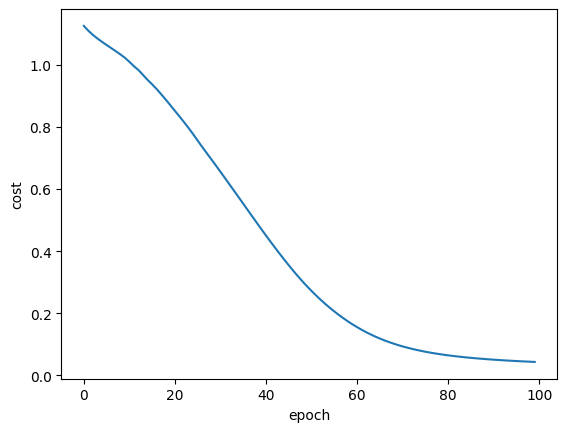

In [47]:
plt.plot(range(epochs), cost_per_epoch)
plt.ylabel("cost")
plt.xlabel("epoch")
plt.show()